# Trade-offs and Best Practices while Synthesizing Sequential Data

Sequential data can be synthesized. However when doing so, various limitations could arise. In this notebook we aim to demonstrate the impact when you aggregate the data and perform operations post synthesis. Will the synthetic data behave similarly at a lesser granularity than what it was synthesized on? Let's find out!

Here's the outline of what we'll do in this notebook:
- Step 1: Create the original dataset
- Step 2: Train the synthesizer
- Step 3: Create a sample of synthetic data for same dimensions as the original data
- Step 4: Compare the distibutions of original vs synthetic data
- Step 5: Do an aggregation operation on both the synthetic data and original data
- Step 6: Compare the aggregated results of both original and synthetic data
- Why do the results vary
- A walk-through of alternative approaches based on usecase requirements
- Conclusion

In [1]:
import numpy as np
from numpy.random import normal
import pandas as pd
import matplotlib.pyplot as plt

from ydata.constraints.constraint import CustomConstraint
from ydata.constraints.engine import ConstraintEngine
from ydata.dataset import Dataset
from ydata.dataset.dataset_type import DatasetType
from ydata.metadata import Metadata
from ydata.synthesizers.timeseries.model import TimeSeriesSynthesizer

### Step 1: Create the original dataset

We first create a toy model which is a simplified version of [Paysim](!https://www.kaggle.com/datasets/ealaxi/paysim1) with the following considerations:

1. One entity only
2. One variable `amount` to be synthesized
4. One calculated attribute `balance` as the cumulative sum of `amount`

The variable `amount` is generated by a Gaussian distribution for which the absolute value is taken.

The sign of the variable `amount` is generated by a Bernouili with $p=0.5$.

$\text{balance}(n+1) = \text{balance}(n) + \text{amount}(n) $

As the Gaussian is symmetric and we chose a Berouili with $p=0.5$, $\text{balance}(n)$ can be seen as a Brownian movement. 

In general, $\text{balance}(n)$ is a Markov chain whose kernel is defined by the probability distribution on`amount`. 

In [2]:
n = 10**5
mu, sigma = 0, 0.1 # mean and standard deviation
q = 0.5  # Probability to CASH_IN

data = 100 * np.abs(np.random.normal(mu, sigma, n)) * np.random.choice([1, -1], n, p=[q, 1 - q])

In [3]:
original_df = pd.DataFrame(data, columns=['amount']).reset_index()

Now that our original data has been created, let's have a pre-view of the data.

In [4]:
# dsiplay a sample of the data

original_df.sample(10)

,index,amount
8554,8554,-4.688416
87226,87226,1.742168
10702,10702,-5.370764
6207,6207,0.397844
59368,59368,4.088387
25520,25520,15.914710
43833,43833,-4.559710
67083,67083,0.106757
2334,2334,-2.461993
29541,29541,0.617417


In [5]:
#the dimensions of the data

original_df.shape

(100000, 2)

In [6]:
#statisical metrics of the original data

original_df.describe()

,index,amount
count,100000.000000,100000.000000
mean,49999.500000,0.003719
std,28867.657797,10.062837
min,0.000000,-48.399881
25%,24999.750000,-6.784857
50%,49999.500000,-0.010093
75%,74999.250000,6.796366
max,99999.000000,46.189537


Now that we understand the data, let's prepare the data that's suitable for YData's synthesizer.

In [7]:
# First create a Dataset object from the pandas DataFrame

original = Dataset(original_df)

In [8]:
# Next create a metadata assuming the dataset is tabular. This allows us to understand what we have
# As the dataset is to be assumed to be regular, meaning with no dependencies than we do not need to provided a dataset_attrs

m = Metadata(dataset=original)

#printing the metadata to check the content
print(m)

[########################################] | 100% Completed |  0.4s
Metadata Summary 
 
Dataset type: TABULAR
Dataset attributes: 
Number of columns: 2
% of duplicate rows: 0
Target column: 

Column detail: 
   Column  Data type Variable type
0   index  numerical           int
1  amount  numerical         float

Warnings: 
Empty DataFrame
Columns: []
Index: []



We see it has automatically created tabular type dataset, with the correct column types. However in our case, we know the dataset we created is a time-series one, and the primary key variable is "index", hence we can set the "sortbykey" dataset attribute to the "index" column name.

In [9]:
metadata = Metadata(dataset_type=DatasetType.TIMESERIES)
dataset_attrs = {
     "sortbykey": "index"
}
m = metadata(original, dataset_attrs)

[########################################] | 100% Completed |  0.4s


In [10]:
print(m)

Metadata Summary 
 
Dataset type: TIMESERIES
Dataset attributes: 
Number of columns: 2
% of duplicate rows: 0
Target column: 

Column detail: 
   Column  Data type Variable type
0   index  numerical           int
1  amount  numerical         float

Warnings: 
Empty DataFrame
Columns: []
Index: []



### Step 2: Train the synthesizer

Since we have prepared our data for synthesis, let us initialize a TimeSeriesSynthesizer and train the same.

In [11]:
synthesizer = TimeSeriesSynthesizer()
synthesizer.fit(original, metadata=m, segment_by=False)

INFO: 2022-07-18 14:56:50,686 [SYNTHESIZER] - Initializing Time Series SYNTHESIZER.
INFO: 2022-07-18 14:56:50,781 [SYNTHESIZER] - Starting the synthetic data modeling process.
INFO: 2022-07-18 14:56:50,788 [SYNTHESIZER] - Synthesizer init.


### Step 3: Create a sample of synthetic data for same dimensions as the original data

In [12]:
sample = synthesizer.sample(n_samples=len(original_df))
synthetic_df = sample.to_pandas()

In [13]:
synthetic_df = sample.to_pandas()

In [14]:
synthetic_df.head()

,index,amount
0,0,10.380330
1,1,-2.957274
2,2,-12.567945
3,3,0.958354
4,4,-31.314292


### Step 4: Compare the distibutions of original vs synthetic data

Since we have generated the synthetic data, we now can compare the marginal distribution and the time-series of the column 'amount'. 

In [15]:
def plot_histogram(df, synth_df, column_name):
    fig, axs = plt.subplots(1, 1, figsize=[25, 10])
    df[column_name].hist(label="ORIGINAL", color="#040404", grid=False, alpha=0.5, log=True, bins=100, density=1)
    synth_df[column_name].hist(label="SYNTHETIC", color="#E32212", grid=False, alpha=0.5, log=True, bins=100, density=1)
    plt.title('Distribution of ' + column_name)
    plt.legend()
    
def plot_timeseries(df, synth_df, column_name):
    fig, axs = plt.subplots(1, 1, sharex=True, figsize=[25, 10])
    fig.suptitle(column_name + " over time")
    df[column_name].plot(label="ORIGINAL", color="#040404", alpha=0.8,  title="ORIGINAL")
    synth_df[column_name].plot(label="SYNTH", color="#E32212", alpha=0.8, title="SYNTH")
    plt.ylabel(column_name)
    plt.xlabel("Time")
    plt.show()

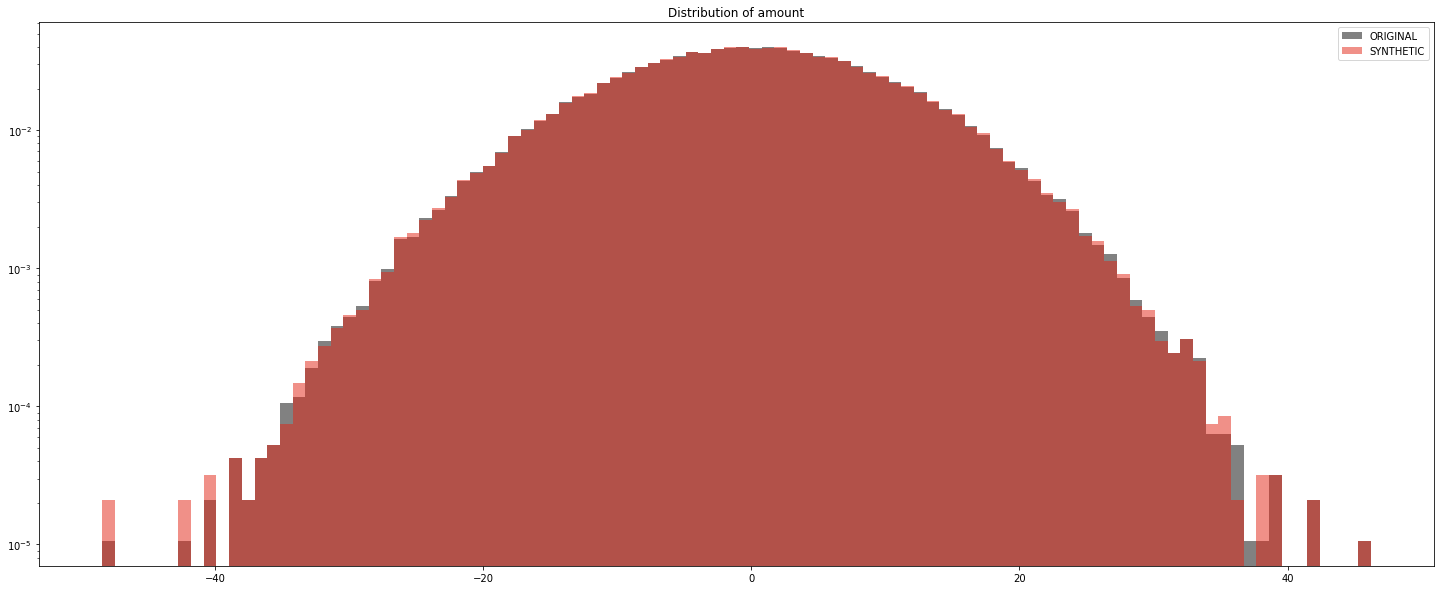

In [16]:
plot_histogram(original_df, synthetic_df, 'amount')

We see that marginal distribution has been synthesized accurately. The black color represents the original data, light red for the synthetic data, and when both values overalaps, a darker red is shown in the diagrams.

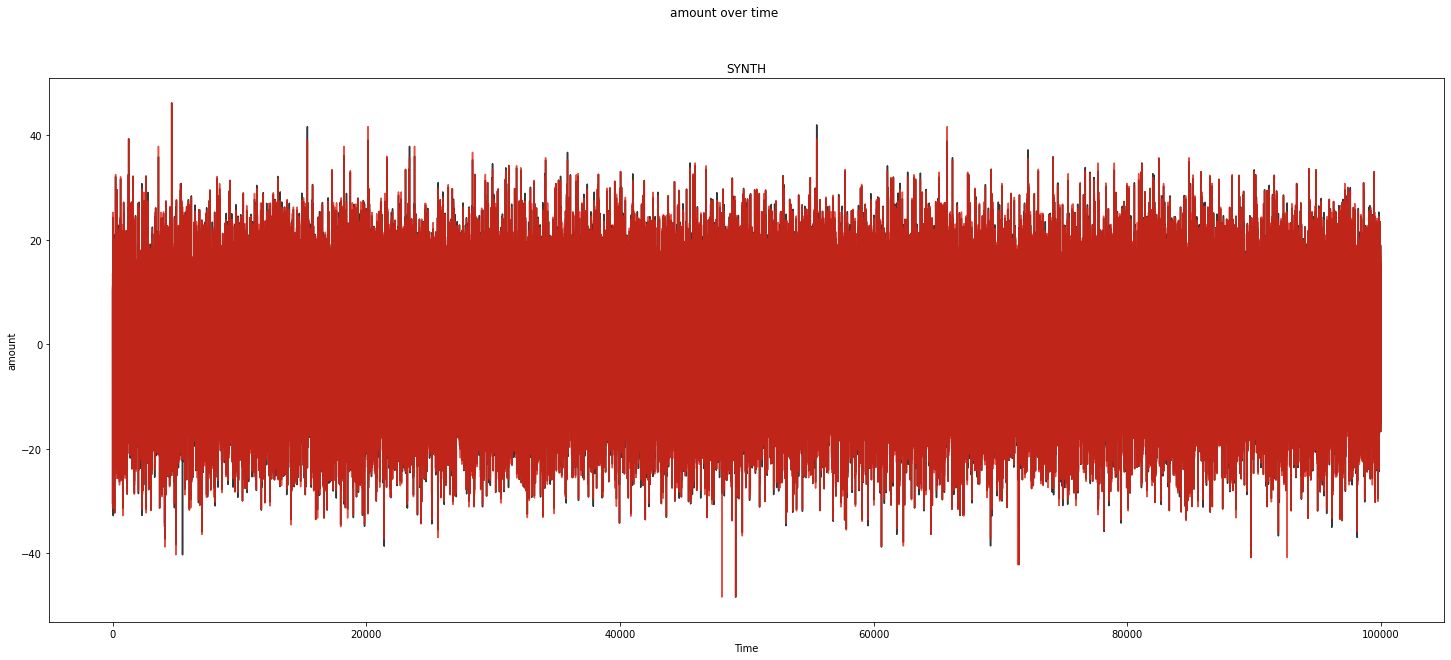

In [17]:
plot_timeseries(original_df, synthetic_df, 'amount')

The amount time-series also follows the same trajectory, hence has been replicated correctly.

### Step 5: Do an aggregation operation on both the synthetic data and original data

We had defined the `balance` variable earlier and will calculate the attribute both on the original and synthetic datasets.

In [18]:
# Calculate the balance from amount (as an aggregation operation)
def calculate_balance(df):
    df['balance'] =  df['amount'].cumsum()
    return df

In [19]:
original_df_agg= calculate_balance(original_df)

synthetic_df_agg = calculate_balance(synthetic_df)

In [20]:
original_df_agg.sample(10)

,index,amount,balance
39141,39141,-2.965077,-4471.178083
17450,17450,2.235718,-2024.764300
98375,98375,7.632500,663.288882
41337,41337,-0.030899,-2912.697141
46411,46411,5.602006,-3882.319029
72120,72120,11.593142,-3861.131692
44236,44236,-1.382987,-3303.933020
20907,20907,-13.218023,-1155.035372
59997,59997,9.303105,-3016.345795
56189,56189,-7.524815,-3578.350310


### Step 6: Compare the aggregated results of both original and synthetic data

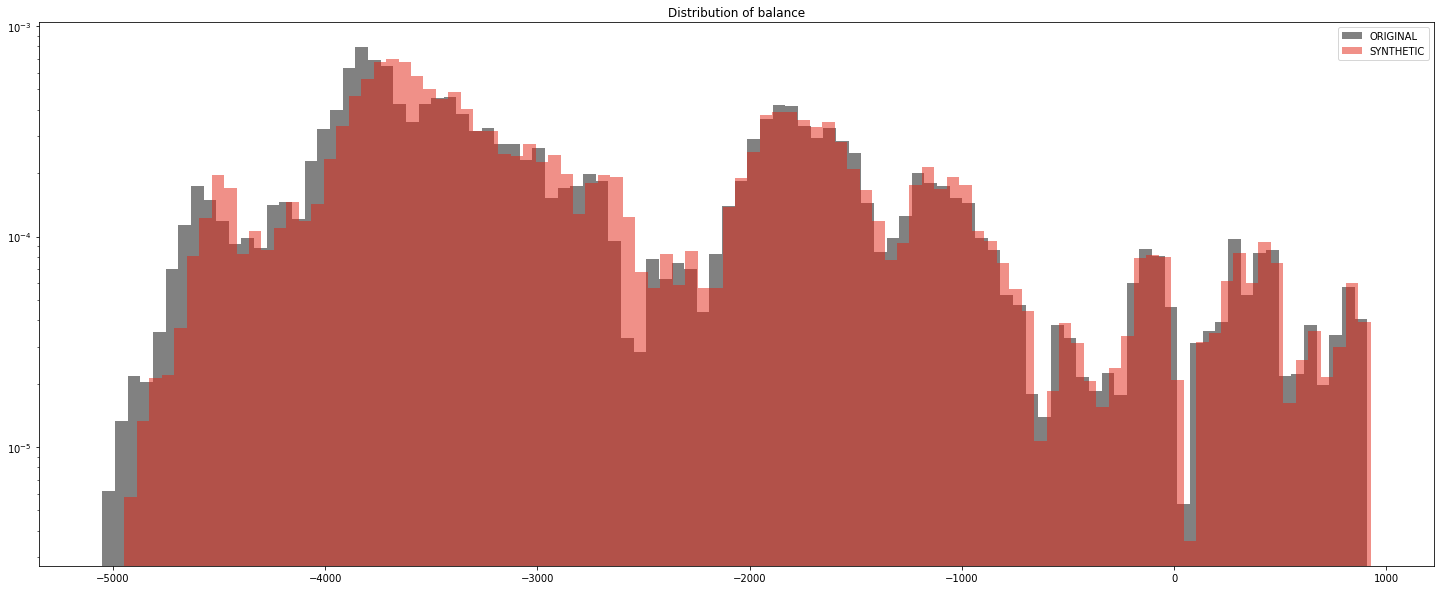

In [21]:
plot_histogram(original_df, synthetic_df, 'balance')

We can see that the marginal distribution of balance values follow a similar distribution to some extent, however, not as similar as how we saw earlier.

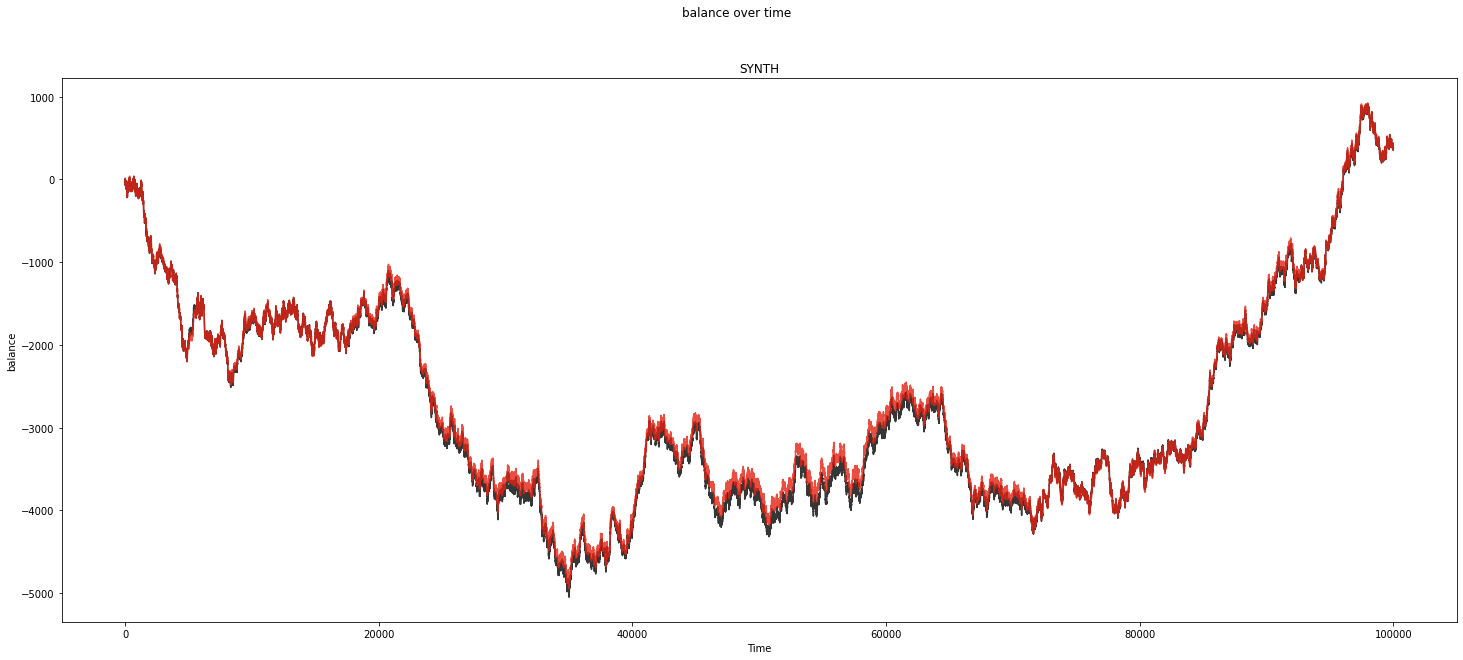

In [22]:
plot_timeseries(original_df, synthetic_df, 'balance')

However, we notice that the balance time-series is different, and is not properly replicated. You may notice the difference between the black (original) and red (synthetic) plots on the graph above.



### Why does this happen?

When we synthesize data at a particular granularity, as it occurs in all kinds of machine learning algorithms, there exists an error. The error is a "sampling error" which occurs both in the original and the synthetic data. 

The original data is a sample from an unknown distribution that the synthesizer tries to infer from the original sample/dataset provided by the user. Then we sample from the learned model such that we introduce a small sample error even if we learned the original distribution perfectly. This is expected and acceptable as it relies only on the quantity of data provided by the user and sampled via the synthesizer.

The problem with the aggregation comes from the "propagation of uncertainty" when the aggregation directly depends on previous timesteps. This was certainly the case with the balance column, as it depends on the amounts of all indexes prior to any given index. 

In this case, the error will be propagated with a certain standard deviation and amplitude, which solely depends on the complexity of the aggregation formula. This error became significant and is visible in the time series and the distribution, as depicted in above figures.


### So what's the alternative?

We had already synthesized the amount column and generated the balance column respecting the constraints. But since the distributions and trajectories were not similar, we now have two other alternatives:
1. Synthesize both amount and balance columns at the same time, evaluating the constraints
2. Synthesize the balance column, and reverse-calculate the amount column, respecting the constraints

For the first alternative, since we're synthesizing both amount and balance columns simultaneously, we will also specify the constraints using a custom function. This will enable us do the constraint validation, later.

In [23]:
# Flag a constraint violation from balance a amount
def flag_constraint_violation(df):
    return df['balance'] == df['amount'].cumsum()

Now that our custom validation function is created, let's create a CustomConstraint object, and then specify it as a metadata.

In [24]:
# create a native CustomConstraint object, using the custom function above
c1 = CustomConstraint(name='Balance Check', 
                      check=flag_constraint_violation, 
                      available_columns=['balance', 'amount'])

constraints = [c1]

Let's evaluate these alternatives, first, synthesize both columns at the same time, by following the same steps as we outlined so far.

In [25]:
original = Dataset(original_df_agg)
metadata = Metadata(dataset_type=DatasetType.TIMESERIES, constraints=constraints)
dataset_attrs = {
     "sortbykey": "index"
}

In [26]:
m = metadata(original, dataset_attrs)

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.4s


In [27]:
m.summary['constraints']

{'violation_count': 0,
 'violation_ratio': 0.0,
 'violation_per_constraint': {'Balance Check': {'violation_count': 0,
   'violation_ratio': 0.0,
   'validation_time': (0.2086336612701416,)}}}

We see that, trivially, the constraints were met in the original data (by construction).

In [28]:
synthesizer = TimeSeriesSynthesizer()
synthesizer.fit(original, metadata=m, segment_by=False)

INFO: 2022-07-18 14:56:59,605 [SYNTHESIZER] - Initializing Time Series SYNTHESIZER.
INFO: 2022-07-18 14:56:59,690 [SYNTHESIZER] - Starting the synthetic data modeling process.
INFO: 2022-07-18 14:56:59,699 [SYNTHESIZER] - Synthesizer init.


In [29]:
sample = synthesizer.sample(n_samples=len(original_df))
synthetic_df_agg = sample.to_pandas()

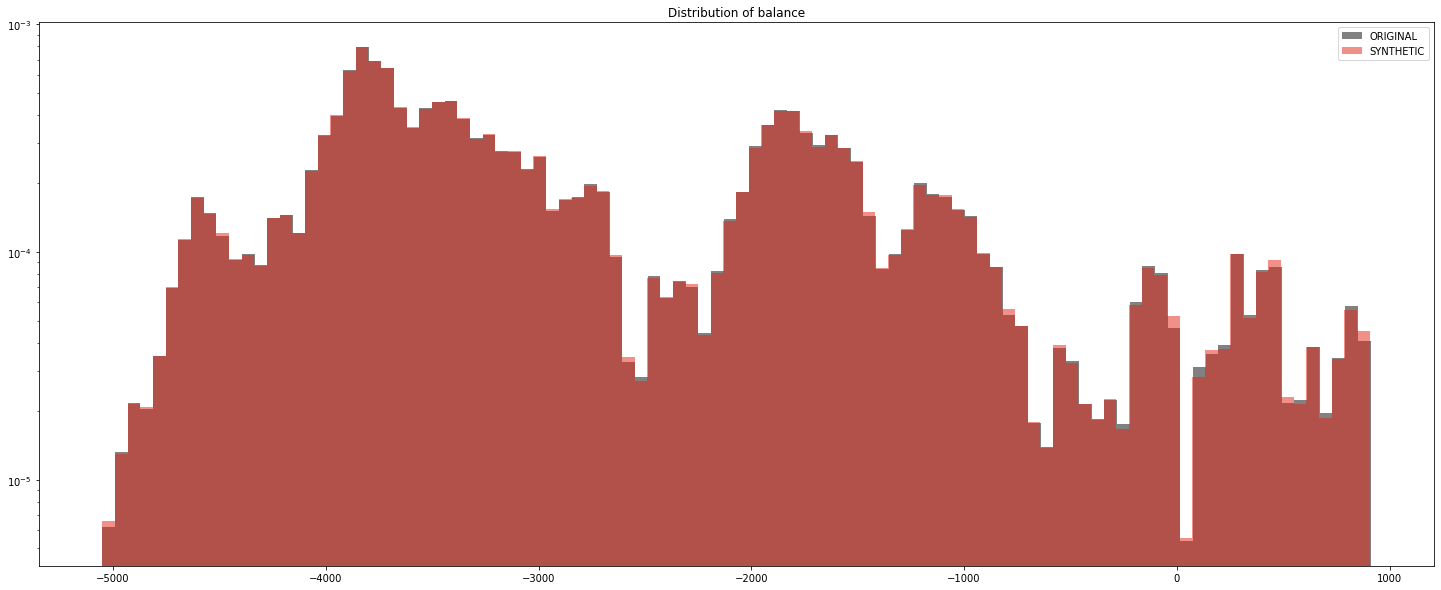

In [30]:
plot_histogram(original_df_agg, synthetic_df_agg, 'balance')

We can infer that the `balance` distribution is almost identical and has been synthesized properly.

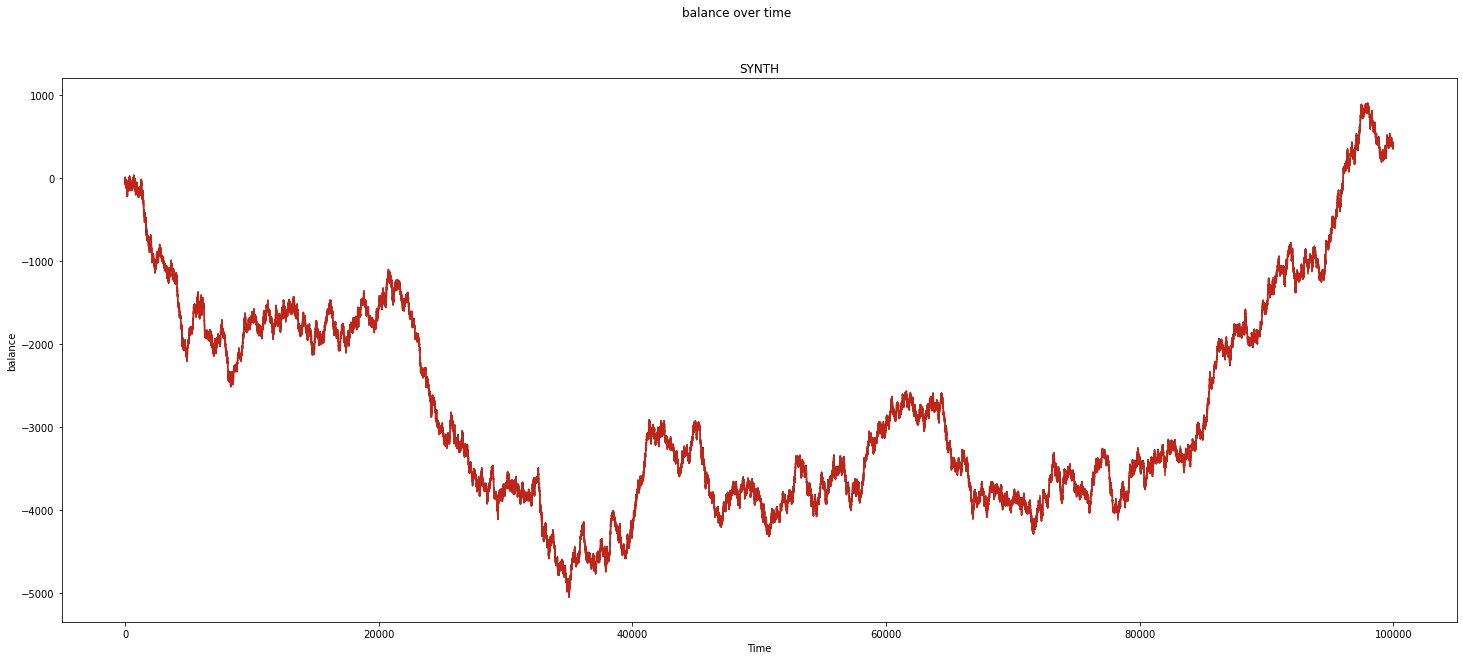

In [31]:
plot_timeseries(original_df_agg, synthetic_df_agg, 'balance')

In [32]:
#convert a pandas dataframe to Dataset Object for the Constraints Engine

synthetic_df_agg_dataset = Dataset(synthetic_df_agg)

ce = ConstraintEngine()
ce.add_constraint(c1)
ce.validate(synthetic_df_agg_dataset)
ce.summary()

{'violation_count': 100000,
 'violation_ratio': 1.0,
 'violation_per_constraint': {'Balance Check': {'violation_count': 100000,
   'violation_ratio': 1.0,
   'validation_time': (0.07214689254760742,)}}}

By synthesizing post aggregation, we see that the synthetic data behaves similar to how the original data would have behaved.

Our alternative method has successfully mitigated the non-similarity issue we faced; however, since we generated both amount and balance columns together, the constraint where the cumulative amount at any given index is equal to the balance is not holding true anymore.

Let us also give our 3rd alternative a go, synthesize the balance column only, and reverse-calculate the amount column.

In [33]:
original_df_agg_balance = original_df_agg.copy()
original_df_agg_balance.drop(columns='amount', inplace=True)

In [34]:
original = Dataset(original_df_agg_balance)
metadata = Metadata(dataset_type=DatasetType.TIMESERIES)
dataset_attrs = {
     "sortbykey": "index"
}

In [35]:
m = metadata(original, dataset_attrs)

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.3s


In [36]:
synthesizer = TimeSeriesSynthesizer()
synthesizer.fit(original, metadata=m, segment_by=False)

INFO: 2022-07-18 14:57:06,727 [SYNTHESIZER] - Initializing Time Series SYNTHESIZER.
INFO: 2022-07-18 14:57:06,808 [SYNTHESIZER] - Starting the synthetic data modeling process.
INFO: 2022-07-18 14:57:06,816 [SYNTHESIZER] - Synthesizer init.


In [37]:
sample = synthesizer.sample(n_samples=len(original_df))
synthetic_df_agg = sample.to_pandas()

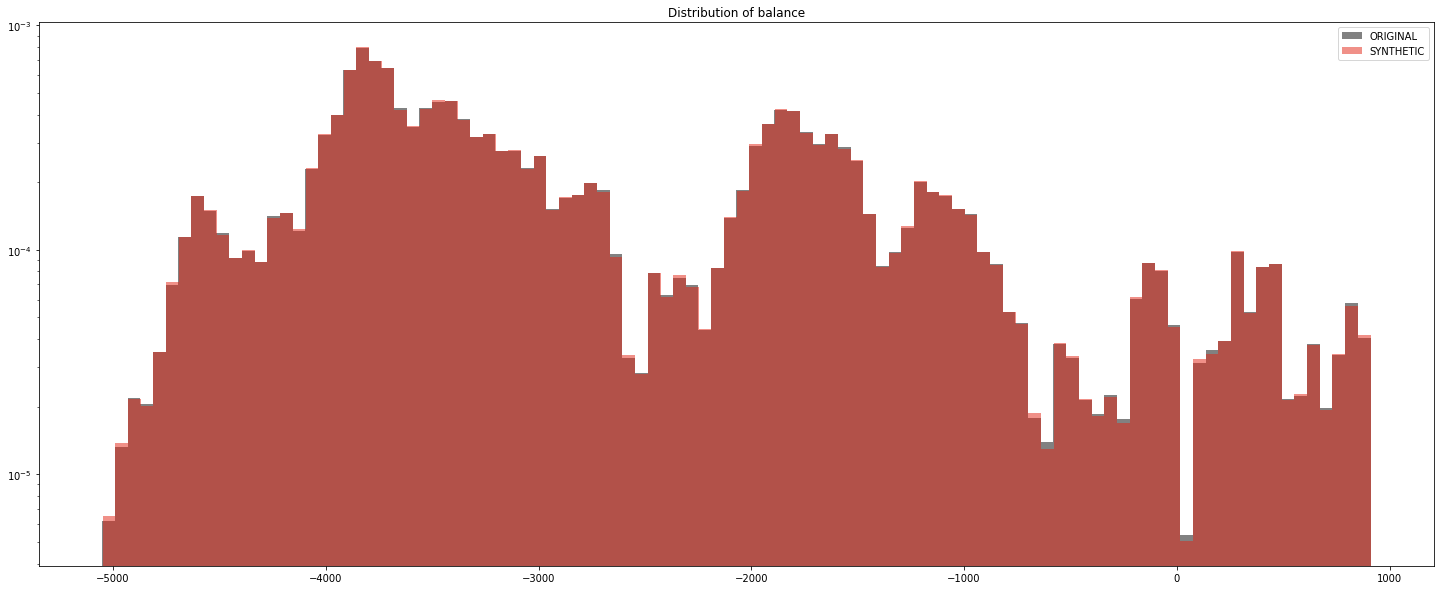

In [38]:
plot_histogram(original_df_agg, synthetic_df_agg, 'balance')

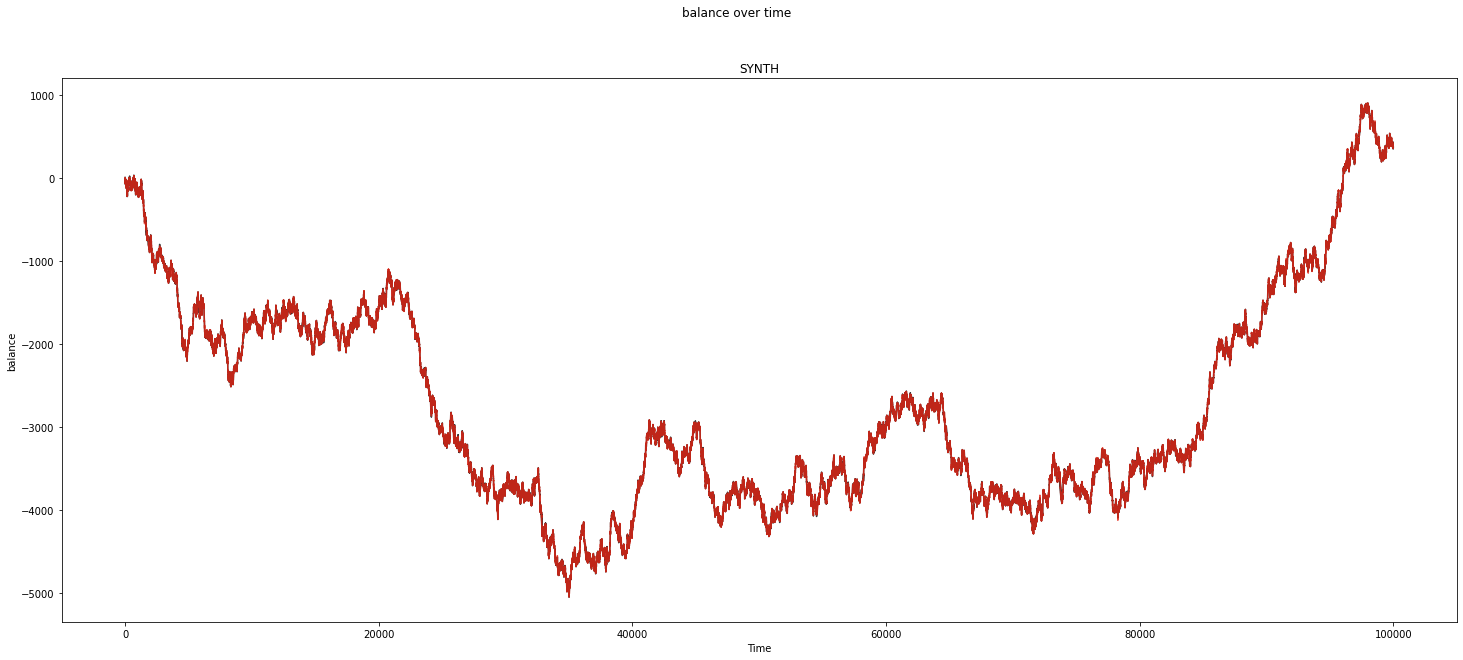

In [39]:
plot_timeseries(original_df_agg, synthetic_df_agg, 'balance')

The balance trajectory and the marginal distributions are now similar and have been accurately replicated as shown in the plots above.

In [40]:
def calculate_amount(sample_df):
    sample_df['__next'] = sample_df['balance'].shift(-1)
    sample_df['amount'] = sample_df.apply(lambda x:  x['__next'] - x['balance'], axis=1)
    sample_df['amount'] = sample_df['amount'].shift(1)
    sample_df.drop(columns='__next', inplace=True)
    return sample_df

In [41]:
synthetic_df_agg_amount = calculate_amount(synthetic_df_agg)

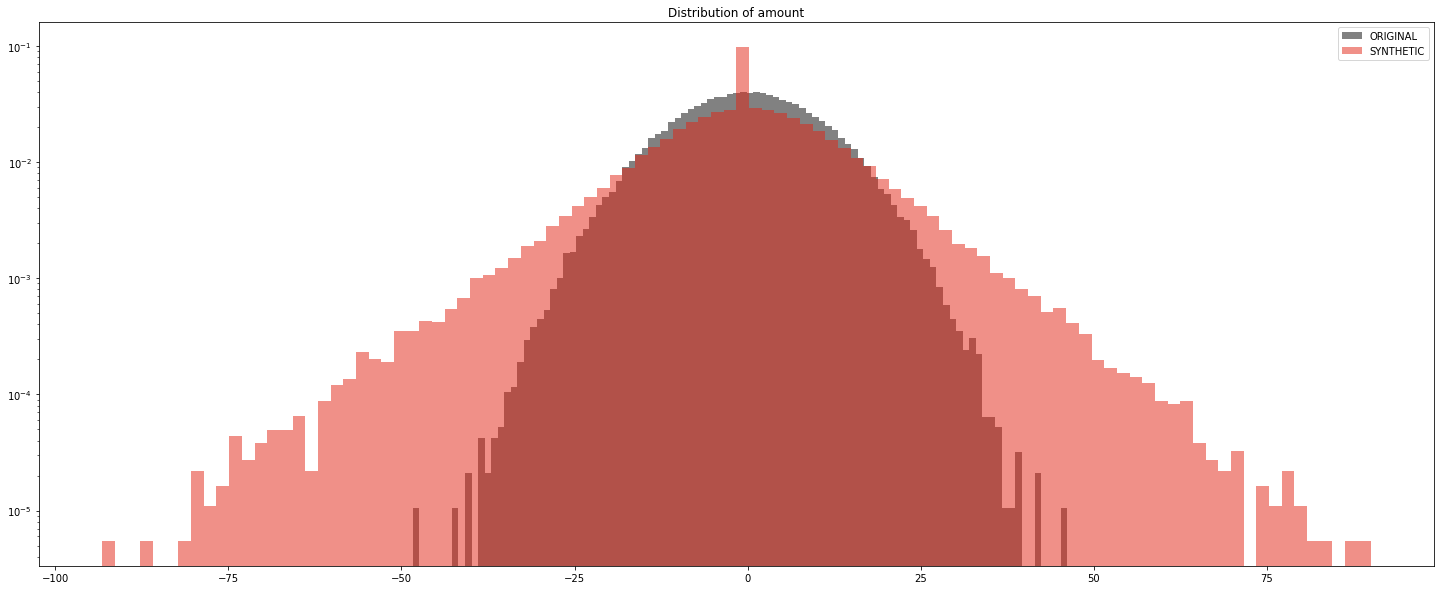

In [42]:
plot_histogram(original_df_agg, synthetic_df_agg, 'amount')

However, we notice that the marginal distribution has not been correctly replicated when we reverse-calculated the amount values.

The trade-off was such that the user must choose between meeting the constraints vs. synthesizing similar columns vs. synthesizing similar aggregated columns, only satisfying two of the above simultaneously.

Suppose our for usecase, we wanted to predict the cash flow status of the bank based on the transactions. We could be more concerned about the similarity in the balance column of both original and synthetic data; thus, this will become a non-negotiable. Suppose we are comfortable with the fact that the constraints might not be respected in the synthetic data. In that case, we will choose to synthesize both columns together so that even the amounts column would follow a similar distribution.

The best approach to synthesizing data would vary from scenario to scenario. However, the user needs to know the tradeoff between these scenarios and synthesize the data at the required granularity after evaluating one's options.